# Study Analysis

Analysis of the study responses, using t-test to assess whether there is a statistically significant difference between the means of the two conditions - user understanding of model predictions with/without LIME explanations.

**User understanding Metric**: Weighted Kappa score of their estimated model predictions versus actual model predictions, across the ten predictions in the study.

## Set-up

### Import libraries

In [89]:
from google.colab import drive
import pandas as pd
import numpy as np
import scipy as sp
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import cohen_kappa_score, mean_squared_error, accuracy_score
import joblib

### Set Pandas display options

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)
pd.set_option('max_seq_item', None)

### Set up working directory

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/My Drive/MSc Data Science/Research Project/data')

In [5]:
!ls

petfinder-adoption-prediction  study_responses_qual_data.csv
study_responses.csv


### Set Random Seed

In [6]:
# Random seed function 

seed=10

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(seed)

## Read in data

In [7]:
df = pd.read_csv('study_responses.csv').set_index(['group','response_id'])

In [8]:
# replace labels with numbers

labels_map = {
    '0-7 Days': 0,
    '8-30 Days':1,
    '31-90 Days':2,
    '100+ Days':3
}

prediction_cols = [col for col in df.columns if 'prediction' in col and 'score' not in col]
for col in prediction_cols:
    df[col] = df[col].apply(lambda x: labels_map[x])
    df[col] = pd.to_numeric(df[col])

In [9]:
# split out predictions and qualitative data

# predictions
preds = df[prediction_cols].copy()

# qualitative data
new_cols = [
            'What part(s) of the information provided for each example did you find most helpful in understanding how the model makes predictions, and why?',
            'What part(s) of the information provided for each example did you find unhelpful and/or confusing in understanding how the model makes predictions, and why?',
            "What additional information would you like to have seen to improve your understanding of the model's predictions?"
]

qual_data = df[['most_useful','least_useful','anything_else']].copy()
qual_data.columns = new_cols


## Weighted Kappa Scores

In [10]:
# define weighted kappa metric
def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [11]:
# calculate weighted kappa scores for each response

# define actual model predictions
actuals = [1,0,2,0,3,2,3,1,3,2]

# calculate scores
qwks = preds.apply(lambda x: qwk(actuals,x),axis=1)

## Descriptive Stats

In [13]:
# isolate treatment and control groups scores
qwks_t = qwks[qwks.index.get_level_values(0)=='Treatment']
qwks_c = qwks[qwks.index.get_level_values(0)=='Control']

In [94]:
# calculate descriptive stats
qwks_desc = pd.concat([qwks_t.describe(),qwks_c.describe()],axis=1)
qwks_desc.columns = ['Treatment','Control']
qwks_desc.T

,count,mean,std,min,25%,50%,75%,max
Treatment,35.0,0.301727,0.299055,-0.310680,0.056730,0.238095,0.562609,0.819820
Control,35.0,0.417246,0.212397,-0.153846,0.253028,0.480000,0.590326,0.710744


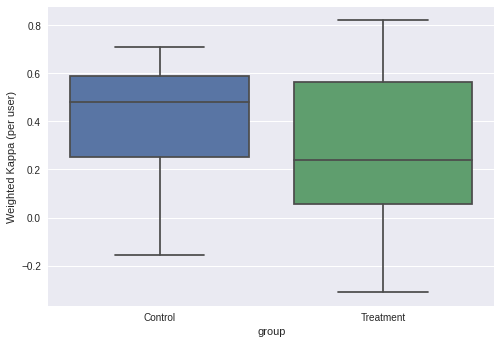

In [88]:
# plot descriptive stats using box plot

qwks_bp = qwks.reset_index().rename(columns={0:'Weighted Kappa (per user)'})

ax = sns.boxplot(x='group',y='Weighted Kappa (per user)',data=qwks_bp)

## Check Distribution

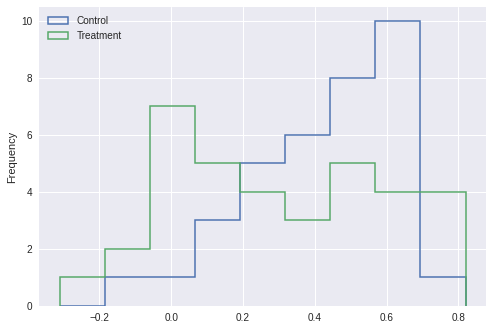

In [109]:
# plot histogram for each group, to see if they're normally distributed
plt.style.use('seaborn')

qwks_dist = pd.concat([qwks_c,qwks_t],axis=1)
qwks_dist.columns = ['Control','Treatment']

# ax = qwks_dist.plot.kde(bw_method=0.3)
ax = qwks_dist.plot.hist(histtype='step',linewidth=1.5,bins=9)
ax.legend(loc='upper left')

plt.show()

## Prediction Accuracy


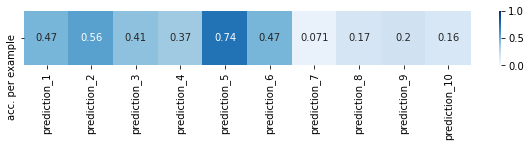

In [ ]:
# calculate prediction accuracy per example overall
accs = (np.sum(np.array(preds.apply(lambda x: np.array(actuals) == np.array(x),axis=1))*1)/preds.shape[0]).reshape(1,-1)

accs = pd.DataFrame(data=accs, columns=preds.columns, index=['acc. per example'])

fig, ax = plt.subplots(figsize=(10,1))
sns.heatmap(accs,vmin=0,vmax=1,cmap='Blues',annot=True, ax=ax)

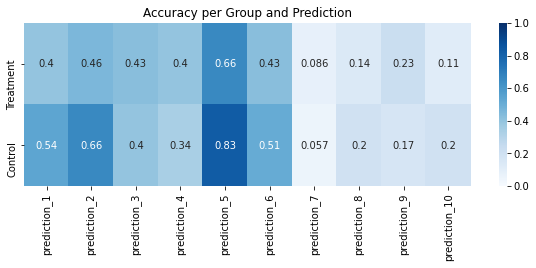

In [ ]:
# calculate prediction accuracy per example (for treatment)
accs_t = (np.sum(np.array(preds[preds.index.get_level_values(0)=='Treatment'].apply(lambda x: np.array(actuals) == np.array(x),axis=1))*1)/\
        preds[preds.index.get_level_values(0)=='Treatment'].shape[0]).reshape(1,-1)

accs_t = pd.DataFrame(data=accs_t, columns=preds.columns, index=['Treatment'])

# calculate prediction accuracy per example (for control)
accs_c = (np.sum(np.array(preds[preds.index.get_level_values(0)=='Control'].apply(lambda x: np.array(actuals) == np.array(x),axis=1))*1)/\
        preds[preds.index.get_level_values(0)=='Control'].shape[0]).reshape(1,-1)

accs_c = pd.DataFrame(data=accs_c, columns=preds.columns, index=['Control'])

accs = pd.concat([accs_t,accs_c],axis=0)

fig, ax = plt.subplots(figsize=(10,3))
ax.set_title('Accuracy per Group and Prediction')
sns.heatmap(accs,vmin=0,vmax=1,cmap='Blues',annot=True, ax=ax)


## Perform t-test

In [96]:
# perform t test, H1 = treatment mean rank greater than control, H0 = not greater
mwu_stat, p_value = sp.stats.mannwhitneyu(x=qwks_t,y=qwks_c,alternative='greater')

print('MWU Test Statistic:',mwu_stat)
print()
print('P-value:',p_value)

MWU Test Statistic: 472.0

P-value: 0.9511753692529502


In [97]:
# perform t test, H1 = treatment mean rank less than control, H0 = not less
mwu_stat, p_value = sp.stats.mannwhitneyu(x=qwks_t,y=qwks_c,alternative='less')

print('MWU Test Statistic:',mwu_stat)
print()
print('P-value:',p_value)

MWU Test Statistic: 472.0

P-value: 0.05002501079555801


## Save outputs

In [ ]:
# output qualitative data
os.chdir('/content/drive/My Drive/MSc Data Science/Research Project/data')
qual_data.to_csv('study_responses_qual_data.csv')